# Hackathon BI Pipeline : Data Science Project

**Team 20**
- Lisa NACCACHE (DIA 4) **Team Leader**
- Hiba NEJJARI (DIA 4)
- Neil MAHCER (DIA 4)
- Wendy DUONG (DIA 4)
- Cyprien MOUTON (DIA 4)
- Safa HORMI BOUAICHI (DIA 3)

# **Machine Learning**

## WatsonIA
## Banking Fraud Detection
## **Context :**

With the rapid expansion of digital banking and online payments, financial institutions face an increasing number of fraud attempts. Fraudsters constantly evolve their methods, making static rule-based detection systems ineffective.

For this hackathon, IBM provided a real-world dataset of banking transactions (2016–2018) to develop and evaluate fraud detection models. The objective is to build a machine learning model capable of predicting whether a transaction is fraudulent (1) or legitimate (0), supporting banks in making real-time, reliable decisions against financial fraud.


# I - Data -processing

## I.1 - Import the libraries.

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.1 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix
from imblearn.ensemble import EasyEnsembleClassifier
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

## I.2 - Uploading Data

**Database Description**


The dataset used in this project comes from IBM’s banking fraud detection challenge and contains real-world banking transactions from 2016 to 2018.
It combines multiple data sources — including transaction details, user profiles, and card information — to identify whether a transaction is fraudulent (1) or legitimate (0).

The file final_dataset_FE.csv represents the cleaned and feature-engineered version of the original data.
All preprocessing steps (missing value handling, merging, encoding, and feature creation) have already been performed, resulting in a ready-to-train dataset containing both raw and engineered features such as:

Transaction-based features (amount, time, MCC, etc.)

User-level features (age, income, credit score, number of cards)

Derived risk indicators (credit risk index, fraud risk index, ratios, etc.)

This dataset will now be used to train and evaluate our machine learning models.


In [ ]:
# Locate and load final dataset (after cleaning and feature engineering)

PATH = "final_dataset_FE.csv"
data = pd.read_csv(PATH)

# Display dataset info
print("Dataset shape:", data.shape)
data.head()



Dataset shape: (199872, 39)


,transaction_id,card_id,amount,mcc,fraud,num_cards_issued,credit_limit,year_pin_last_changed,current_age,retirement_age,...,mcc_encoded,debt_to_income,credit_utilization,credit_risk_index,age_group,age_group_encoded,retirement_proximity,account_age_days,days_to_expiry,fraud_risk_index
0,19765990,2519,12.35,5942,0,1,26596.0,2015,38.0,65.0,...,0.018997,1.244457,0.599887,0.000091,26–40,1,0.424242,20398,0,0.379250
1,22160255,4049,58.29,5814,0,2,10200.0,2016,25.0,65.0,...,0.039250,1.506721,0.269378,0.001102,26–40,1,0.621212,20398,0,0.440064
2,17566794,3367,11.03,5411,0,2,38120.0,2011,55.0,74.0,...,0.128242,0.011101,0.616888,0.000028,41–60,2,0.266667,20398,0,0.178424
3,17318690,3457,85.74,5411,0,1,35073.0,2009,74.0,66.0,...,0.128242,0.067168,0.649332,0.000204,61–80,3,0.000000,20398,0,0.160849
4,20994060,2800,13.43,4214,0,1,5800.0,2009,54.0,63.0,...,0.008876,1.402770,0.165961,0.000270,41–60,2,0.156250,20398,0,0.376789


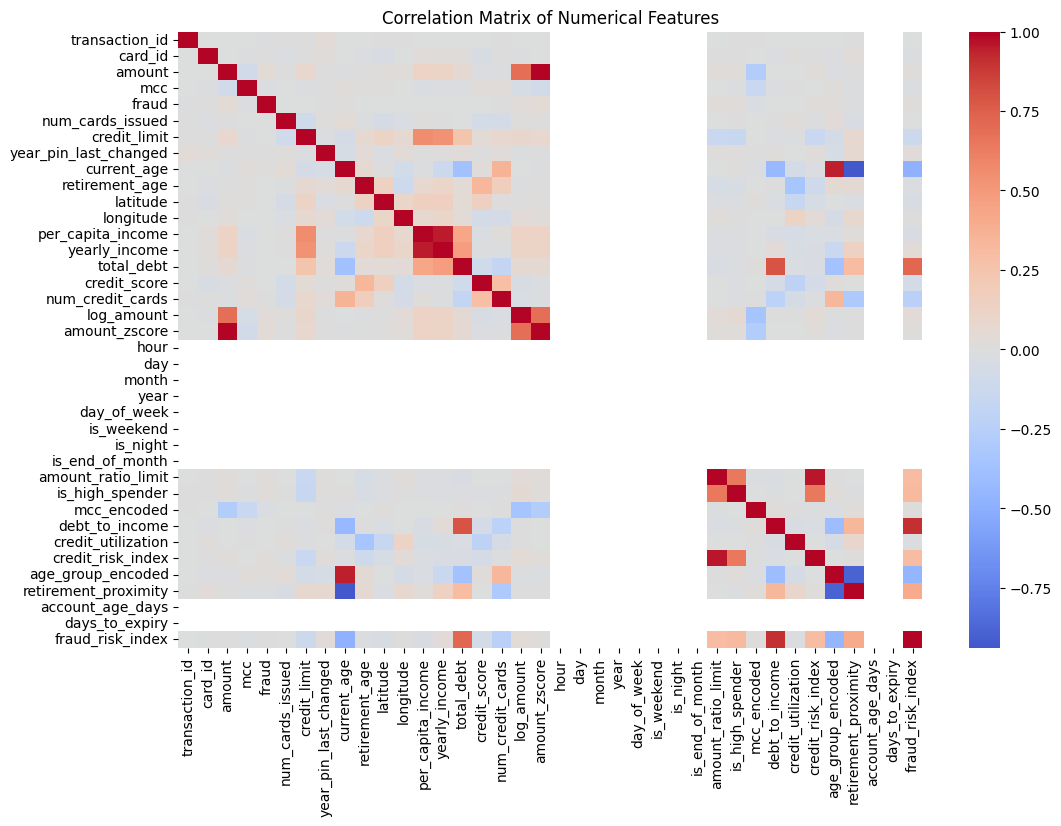

Correlation of each variable with 'fraud':

fraud                    1.000000
amount                   0.043068
amount_zscore            0.043068
log_amount               0.023735
is_high_spender          0.022641
credit_risk_index        0.019211
amount_ratio_limit       0.019002
age_group_encoded        0.008944
current_age              0.008824
fraud_risk_index         0.008320
num_credit_cards         0.005140
card_id                  0.002153
year_pin_last_changed    0.001925
credit_score             0.000265
latitude                 0.000194
num_cards_issued         0.000157
credit_utilization      -0.000869
debt_to_income          -0.001329
longitude               -0.002036
retirement_age          -0.002225
total_debt              -0.002919
per_capita_income       -0.003333
yearly_income           -0.004320
credit_limit            -0.006292
transaction_id          -0.008942
retirement_proximity    -0.009593
mcc                     -0.014920
mcc_encoded             -0.028344
hour

In [ ]:
# Correlation analysis
# Keep only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_mat = numeric_df.corr()

# Display correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_mat, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Correlation with the target 'fraud'
target_corr = corr_mat['fraud'].sort_values(ascending=False)
print("Correlation of each variable with 'fraud':\n")
print(target_corr)


## I.3 - Data scaling

To achieve better classification performance, it is necessary to reduce the undesirable effects of outliers by scaling the data to a standard range.

In [ ]:
# Make a copy to avoid altering the original dataset
scaled_df = df.copy()

# Drop non-feature columns
id_cols = ['transaction_id', 'card_id']
target_col = 'fraud'

# Select numeric columns (excluding IDs and target)
numeric_cols = scaled_df.select_dtypes(include=['number']).columns.difference(id_cols + [target_col])

# Initialize scaler
scaler = StandardScaler()

# Fit-transform only numeric feature columns
scaled_df[numeric_cols] = scaler.fit_transform(scaled_df[numeric_cols])

print("✅ Numeric features successfully standardized.")

# Show summary
print(f"Scaled features: {len(numeric_cols)} columns scaled.")
scaled_df.head()



✅ Numeric features successfully standardized.
Scaled features: 35 columns scaled.


,transaction_id,card_id,amount,mcc,fraud,num_cards_issued,credit_limit,year_pin_last_changed,current_age,retirement_age,...,mcc_encoded,debt_to_income,credit_utilization,credit_risk_index,age_group,age_group_encoded,retirement_proximity,account_age_days,days_to_expiry,fraud_risk_index
0,19765990,2519,-0.512583,0.400271,0,-0.978602,0.968744,1.180578,-0.992538,-0.334390,...,-1.020817,0.008248,-0.020861,-0.117119,26–40,-1.380419,1.018189,0.0,0.0,0.042435
1,22160255,4049,0.114867,0.257056,0,0.960864,-0.447472,1.525377,-1.806381,-0.334390,...,-0.499062,0.301961,-0.022757,-0.106508,26–40,-1.380419,2.073011,0.0,0.0,0.439126
2,17566794,3367,-0.530612,-0.193845,0,0.960864,1.964138,-0.198618,0.071718,1.772404,...,1.793540,-1.373005,-0.020764,-0.117774,41–60,-0.240481,0.174332,0.0,0.0,-1.267561
3,17318690,3457,0.489779,-0.193845,0,-0.978602,1.700951,-0.888216,1.261180,-0.100302,...,1.793540,-1.310215,-0.020578,-0.115929,61–80,0.899456,-1.253734,0.0,0.0,-1.382203
4,20994060,2800,-0.497832,-1.533121,0,-0.978602,-0.827525,-0.888216,0.009115,-0.802567,...,-1.281565,0.185545,-0.023350,-0.115243,41–60,-0.240481,-0.416976,0.0,0.0,0.026379


## I.4 - Splitting the data into input (X) and output (Y)

In [ ]:
# Drop non-feature columns and target
X = scaled_df.drop(columns=['fraud', 'transaction_id', 'card_id'])
Y = scaled_df['fraud']

print("Input shape (X):", X.shape)
print("Output shape (Y):", Y.shape)

Input shape (X): (199872, 36)
Output shape (Y): (199872,)


**Display the degree of imbalance in the data**

1. Quantify imbalance → calculate the proportion of majority (non-fraud) and minority (fraud) classes.

2. Visualize imbalance → graph the distribution of classes to highlight the imbalance.

3. What do you observe? Propose a solution for this imbalance problem

Number of non-fraudulent transactions: 199572 (99.850% of total)
Number of fraudulent transactions: 300 (0.150% of total)


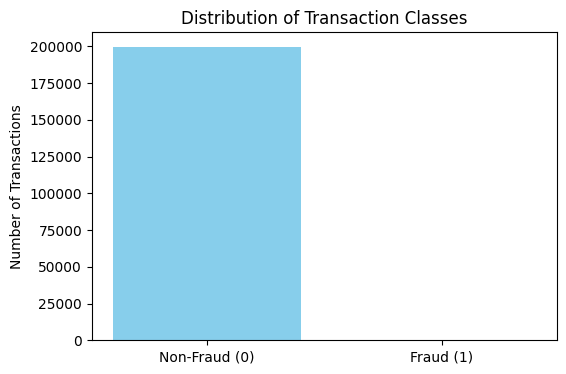

In [ ]:
# Count each class
count_classes = df['fraud'].value_counts()
total = len(df)

# Calculate proportions
non_fraud = count_classes[0]
fraud = count_classes[1]

# Print class distribution
print(f"Number of non-fraudulent transactions: {non_fraud} ({(non_fraud/total)*100:.3f}% of total)")
print(f"Number of fraudulent transactions: {fraud} ({(fraud/total)*100:.3f}% of total)")

# Plot class imbalance
plt.figure(figsize=(6,4))
plt.bar(['Non-Fraud (0)', 'Fraud (1)'], [non_fraud, fraud], color=['skyblue', 'salmon'])
plt.title("Distribution of Transaction Classes")
plt.ylabel("Number of Transactions")
plt.show()




## I.5- Split train/test data

In [ ]:
# Split data while preserving class distribution (stratify = Y)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.3,
    stratify=Y,
    random_state=42
)

# Display shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (139910, 36)
X_test shape: (59962, 36)
y_train shape: (139910,)
y_test shape: (59962,)


After splitting, the training set contains 70% of the transactions (139,910 observations), and the test set contains 30% (59,962 observations).

The split is stratified to preserve the original fraud-to-non-fraud ratio in both sets.

# II- Balancing training data

Since fraudulent transactions represent a very small fraction of all records, the dataset is highly imbalanced. To ensure that the model learns to detect rare fraud cases effectively, we apply data balancing techniques on the training set.

SMOTE generates synthetic samples for the minority class (fraud) to balance the class distribution.
Borderline-SMOTE focuses on creating new synthetic examples near the decision boundary to improve classification around critical regions.

We will use:

- The original training data (X_train, y_train)

- A balanced version using SMOTE (X_train_smote, y_train_smote)

- A balanced version using Borderline-SMOTE (X_train_bsmote, y_train_bsmote)-

In [ ]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

# Make a copy of training data
X_train_num = X_train.select_dtypes(include=['number']).copy()  # Keep only numeric columns
y_train_num = y_train.copy()

# Initialize oversampling methods
smote = SMOTE(random_state=42)
bsmote = BorderlineSMOTE(random_state=42)

# Apply SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train_num, y_train_num)

# Apply Borderline-SMOTE
X_train_bsmote, y_train_bsmote = bsmote.fit_resample(X_train_num, y_train_num)

# Display class distributions
print("Original class distribution:\n", y_train.value_counts(normalize=True))
print("\nAfter SMOTE:\n", y_train_smote.value_counts(normalize=True))
print("\nAfter Borderline-SMOTE:\n", y_train_bsmote.value_counts(normalize=True))




Original class distribution:
 fraud
0    0.998499
1    0.001501
Name: proportion, dtype: float64

After SMOTE:
 fraud
0    0.5
1    0.5
Name: proportion, dtype: float64

After Borderline-SMOTE:
 fraud
0    0.5
1    0.5
Name: proportion, dtype: float64


**Observing the class distributions:**

Before applying SMOTE or Borderline-SMOTE, the dataset was highly imbalanced, with fraudulent transactions representing only about 0.15% of all records.
After resampling, both techniques successfully created a balanced dataset (50% fraud, 50% non-fraud), allowing the model to learn from sufficient fraud examples.

This ensures that the model will not be biased toward predicting only non-fraudulent transaction

#III- Classification with Advanced Models

## III-1- LightGBM

In [ ]:
# Drop non-numeric columns like 'age_group'
X_train_smote = X_train_smote.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])


We remove non-numeric columns such as **`age_group`** because LightGBM only supports numerical input features.

Since this information is already represented by the encoded column **`age_group_encoded`**, dropping the original text column prevents data type errors and ensures consistent model training.


Positive class weight (fraud): 665.24

Preparing data for temporal validation...
Temporal validation data prepared successfully.

Training LightGBM (temporal split)...
[LightGBM] [Info] Number of positive: 242, number of negative: 159655
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4394
[LightGBM] [Info] Number of data points in the train set: 159897, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001513 -> initscore=-6.491833
[LightGBM] [Info] Start training from score -6.491833
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.802445	valid_0's binary_logloss: 2.98689

LightGBM (temporal split) Metrics:
AUROC: 0.8024 | AUPRC: 0.0076 | F1-score: 0.009
Confusion Matrix:
 [[30036  9881

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


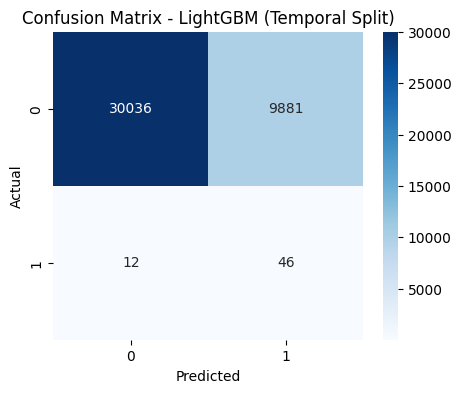


Best F1-score: 0.0092 found at threshold = 0.05


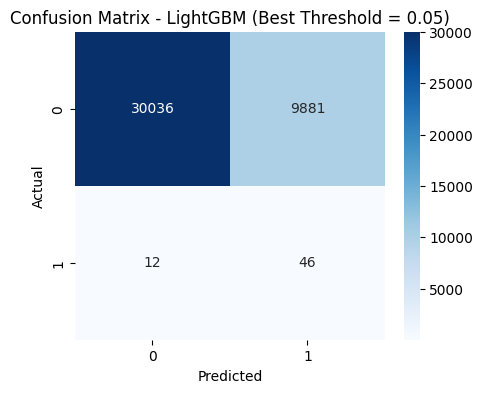


Optimal threshold for LightGBM (Temporal Split): 1.0000
F1-score (optimal threshold): 0.000
Confusion Matrix (optimal threshold):
 [[39916     1]
 [   58     0]]


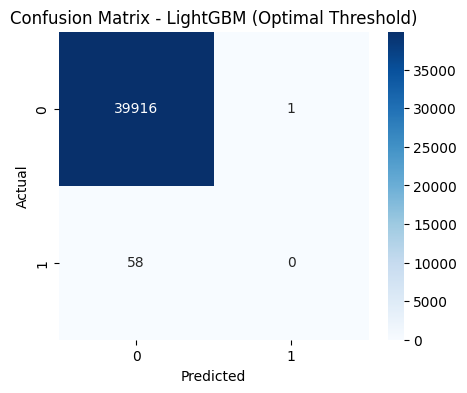

LightGBM model saved successfully.


In [54]:
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    confusion_matrix, precision_recall_curve
)
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import joblib

# Step 1: Compute imbalance weight
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
print("Positive class weight (fraud):", round(scale_pos_weight, 2))

# Columns to exclude from features
cols_to_drop_for_X_features = [
    "fraud", "transaction_id", "card_id", "client_id", "date",
    "merchant_city", "merchant_state", "address", "card_number",
    "acct_open_date", "id", "id_card", "id_user",
    "age_group", "temp_sort_key"
]

# Step 2: Temporal split
print("\nPreparing data for temporal validation...")
data['temp_sort_key'] = (
    data['year'] * 100000000
    + data['month'] * 1000000
    + data['day'] * 10000
    + data['hour'] * 100
)
data_sorted_time = data.sort_values(by='temp_sort_key').copy()

split_index_time = int(0.8 * len(data_sorted_time))
train_time_df = data_sorted_time.iloc[:split_index_time]
test_time_df = data_sorted_time.iloc[split_index_time:]

y_train_time = train_time_df["fraud"].astype(int)
y_test_time = test_time_df["fraud"].astype(int)

X_train_time = train_time_df.drop(
    columns=[c for c in cols_to_drop_for_X_features if c in train_time_df.columns],
    errors="ignore"
)
X_test_time = test_time_df.drop(
    columns=[c for c in cols_to_drop_for_X_features if c in test_time_df.columns],
    errors="ignore"
)

# Encode 'mcc' if needed
if 'mcc' in X_train_time.columns and X_train_time['mcc'].dtype == 'object':
    le_mcc_time = LabelEncoder()
    X_train_time['mcc'] = le_mcc_time.fit_transform(X_train_time['mcc'].astype(str))
    test_values_str_mcc = X_test_time['mcc'].astype(str)
    X_test_time['mcc'] = pd.Categorical(test_values_str_mcc, categories=le_mcc_time.classes_).codes
    X_test_time['mcc'] = X_test_time['mcc'].replace(-1, len(le_mcc_time.classes_))

# Scale features
X_train_time_scaled = scaler.fit_transform(X_train_time)
X_test_time_scaled = scaler.transform(X_test_time)
print("Temporal validation data prepared successfully.")

# Step 3: Train LightGBM
print("\nTraining LightGBM (temporal split)...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=800,
    learning_rate=0.03,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight * 5,  # Heavier weight for fraud class
    objective="binary",
    random_state=42
)

# Fit model with early stopping
lgb_model.fit(
    X_train_time_scaled, y_train_time,
    eval_set=[(X_test_time_scaled, y_test_time)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)


# Step 4: Evaluate model
y_proba = lgb_model.predict_proba(X_test_time_scaled)[:, 1]
y_pred = (y_proba > 0.5).astype(int)
# Save variables for comparison later
y_proba_lgb = y_proba
y_pred_lgb = y_pred


roc_auc = roc_auc_score(y_test_time, y_proba)
auprc = average_precision_score(y_test_time, y_proba)
f1 = f1_score(y_test_time, y_pred)
cm = confusion_matrix(y_test_time, y_pred)

print("\nLightGBM (temporal split) Metrics:")
print(f"AUROC: {roc_auc:.4f} | AUPRC: {auprc:.4f} | F1-score: {f1:.3f}")
print("Confusion Matrix:\n", cm)

# Step 5: Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - LightGBM (Temporal Split)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 5.1: Automatically test multiple thresholds for the best F1
thresholds = np.arange(0.05, 0.95, 0.05)
best_f1, best_t = 0, 0

for t in thresholds:
    y_pred_t = (y_proba > t).astype(int)
    f1_t = f1_score(y_test_time, y_pred_t)
    if f1_t > best_f1:
        best_f1, best_t = f1_t, t

print(f"\nBest F1-score: {best_f1:.4f} found at threshold = {best_t:.2f}")

# Evaluate again using the best threshold
y_pred_best = (y_proba > best_t).astype(int)
cm_best = confusion_matrix(y_test_time, y_pred_best)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - LightGBM (Best Threshold = {best_t:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Step 6: Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test_time, y_proba)
f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nOptimal threshold for LightGBM (Temporal Split): {best_threshold:.4f}")

# Recalculate metrics with optimal threshold
y_pred_opt = (y_proba > best_threshold).astype(int)
f1_opt = f1_score(y_test_time, y_pred_opt)
cm_opt = confusion_matrix(y_test_time, y_pred_opt)

print(f"F1-score (optimal threshold): {f1_opt:.3f}")
print("Confusion Matrix (optimal threshold):\n", cm_opt)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - LightGBM (Optimal Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 7: Save trained model
joblib.dump(lgb_model, "LightGBM_temporal.pkl")
print("LightGBM model saved successfully.")



The LightGBM model with temporal validation achieved an AUROC of 0.8024, showing a moderate ability to separate fraudulent from non-fraudulent transactions. However, the AUPRC (0.0076) and F1-score (0.009) remain very low, indicating that despite its ranking power, the model still struggles to correctly classify fraud cases.

Even after extensive feature engineering, the confusion matrices reveal that the model predominantly predicts non-fraudulent transactions while missing most frauds. This suggests that the challenge lies mainly in the extreme class imbalance rather than the model’s structure or input features.

To improve detection, further tuning of class weights, oversampling methods, or ensemble approaches could help strengthen the model’s sensitivity to rare fraud events.

---


## III- 2- XGBoost section



Training XGBoost (temporal split)...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:30:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost (temporal split) Metrics:
AUROC: 0.7711 | AUPRC: 0.0691 | F1-score: 0.081
Confusion Matrix:
 [[39643   274]
 [   44    14]]


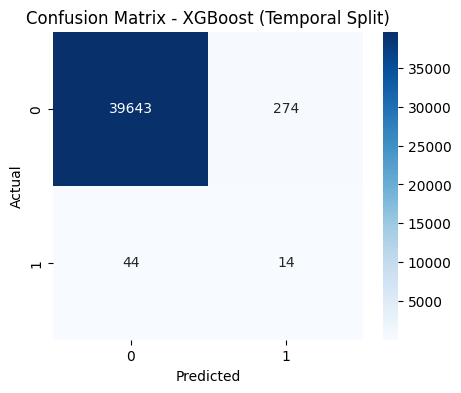


Optimal threshold for XGBoost (Temporal Split): 0.9571
F1-score (optimal threshold): 0.116
Confusion Matrix (optimal threshold):
 [[39894    23]
 [   53     5]]


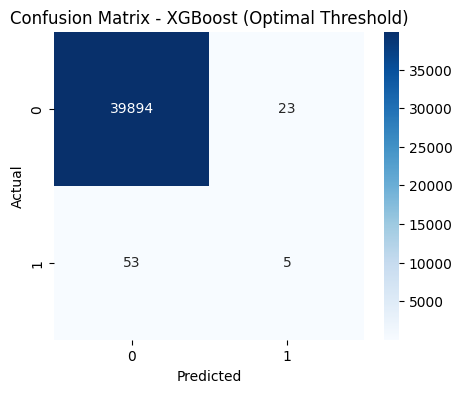

XGBoost model saved successfully.


In [ ]:
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix, precision_recall_curve
import joblib

print("\nTraining XGBoost (temporal split)...")

# Initialize XGBoost with tuned parameters for imbalance
xgb_model = XGBClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight * 5,  # emphasize fraud class
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    use_label_encoder=False
)

# Fit model
xgb_model.fit(
    X_train_time_scaled, y_train_time,
    eval_set=[(X_test_time_scaled, y_test_time)],
    verbose=False
)

# Predictions
y_proba_xgb = xgb_model.predict_proba(X_test_time_scaled)[:, 1]
y_pred_xgb = (y_proba_xgb > 0.5).astype(int)

# Evaluate
roc_auc_xgb = roc_auc_score(y_test_time, y_proba_xgb)
auprc_xgb = average_precision_score(y_test_time, y_proba_xgb)
f1_xgb = f1_score(y_test_time, y_pred_xgb)
cm_xgb = confusion_matrix(y_test_time, y_pred_xgb)

print("\nXGBoost (temporal split) Metrics:")
print(f"AUROC: {roc_auc_xgb:.4f} | AUPRC: {auprc_xgb:.4f} | F1-score: {f1_xgb:.3f}")
print("Confusion Matrix:\n", cm_xgb)

# Confusion Matrix Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost (Temporal Split)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Find optimal threshold
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test_time, y_proba_xgb)
f1_scores_xgb = 2 * precision_xgb * recall_xgb / (precision_xgb + recall_xgb + 1e-6)
best_threshold_xgb = thresholds_xgb[f1_scores_xgb.argmax()]

print(f"\nOptimal threshold for XGBoost (Temporal Split): {best_threshold_xgb:.4f}")
y_pred_custom_xgb = (y_proba_xgb > best_threshold_xgb).astype(int)

# Evaluate with optimal threshold
cm_opt_xgb = confusion_matrix(y_test_time, y_pred_custom_xgb)
f1_opt_xgb = f1_score(y_test_time, y_pred_custom_xgb)

print(f"F1-score (optimal threshold): {f1_opt_xgb:.3f}")
print("Confusion Matrix (optimal threshold):\n", cm_opt_xgb)

# Plot optimal confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_opt_xgb, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost (Optimal Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(xgb_model, "XGBoost_temporal.pkl")
print("XGBoost model saved successfully.")




The XGBoost model trained with the temporal split achieved moderate discriminative power with an AUROC of 0.77 and an AUPRC of 0.069, showing that it can capture some temporal patterns of fraudulent behavior.

 However, the low F1-score and small number of true positives indicate that the model still struggles to consistently identify fraud cases within a highly imbalanced dataset.
.

## III- 3- CatBoost section



Training CatBoost (temporal split)...
0:	test: 0.5924772	best: 0.5924772 (0)	total: 240ms	remaining: 5m 59s
100:	test: 0.7957980	best: 0.8195780 (23)	total: 17s	remaining: 3m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.819577995
bestIteration = 23

Shrink model to first 24 iterations.

CatBoost (temporal split) Metrics:
AUROC: 0.8196 | AUPRC: 0.0227 | F1-score: 0.0095
Confusion Matrix:
 [[31346  8571]
 [   17    41]]


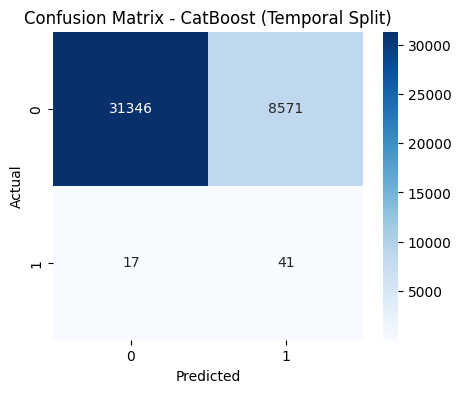


Optimal threshold for CatBoost (Temporal Split): 0.7385
F1-score (optimal threshold): 0.0526
Confusion Matrix (optimal threshold):
 [[39901    16]
 [   56     2]]


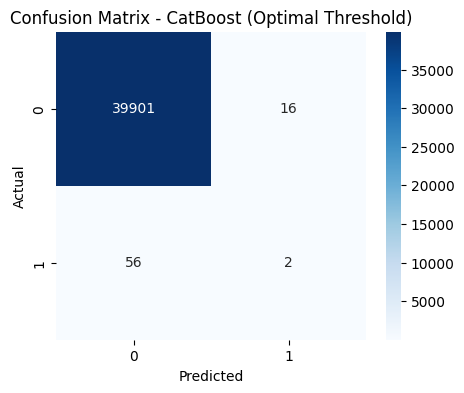

CatBoost model saved successfully.


In [ ]:
from catboost import CatBoostClassifier, Pool
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix, precision_recall_curve
import numpy as np
import joblib

# Step 1: Define model with tuned hyperparameters
print("\nTraining CatBoost (temporal split)...")

cat_model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.02,
    depth=8,
    l2_leaf_reg=5,
    random_seed=42,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=[1, scale_pos_weight * 2],
    subsample=0.8,
    colsample_bylevel=0.8,
    early_stopping_rounds=100,
    verbose=100
)

# Step 2: Prepare CatBoost Pool (handles categorical automatically if needed)
train_pool = Pool(X_train_time_scaled, y_train_time)
test_pool = Pool(X_test_time_scaled, y_test_time)

# Step 3: Fit model with evaluation set
cat_model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True
)

# Step 4: Evaluate model performance
y_proba = cat_model.predict_proba(X_test_time_scaled)[:, 1]
y_pred = (y_proba > 0.5).astype(int)

roc_auc = roc_auc_score(y_test_time, y_proba)
auprc = average_precision_score(y_test_time, y_proba)
f1 = f1_score(y_test_time, y_pred)
cm = confusion_matrix(y_test_time, y_pred)

print("\nCatBoost (temporal split) Metrics:")
print(f"AUROC: {roc_auc:.4f} | AUPRC: {auprc:.4f} | F1-score: {f1:.4f}")
print("Confusion Matrix:\n", cm)

# Step 5: Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - CatBoost (Temporal Split)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 6: Compute optimal decision threshold
precision, recall, thresholds = precision_recall_curve(y_test_time, y_proba)
f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
best_threshold = thresholds[f1_scores.argmax()]
print(f"\nOptimal threshold for CatBoost (Temporal Split): {best_threshold:.4f}")

# Step 7: Evaluate again with optimal threshold
y_pred_opt = (y_proba > best_threshold).astype(int)
f1_opt = f1_score(y_test_time, y_pred_opt)
cm_opt = confusion_matrix(y_test_time, y_pred_opt)

print(f"F1-score (optimal threshold): {f1_opt:.4f}")
print("Confusion Matrix (optimal threshold):\n", cm_opt)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - CatBoost (Optimal Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 8: Save trained model
joblib.dump(cat_model, "CatBoost_temporal.pkl")
print("CatBoost model saved successfully.")


The CatBoost model performs better overall, with a higher AUROC (0.82) showing improved ability to distinguish fraud from non-fraud.

It detects more fraudulent cases than before, though it also produces more false positives ; a reasonable trade-off in fraud detection where catching more frauds is usually more important.


## III- 4- BalancedRandomForestClassifier


Training Balanced Random Forest (temporal split)...

Balanced Random Forest (temporal split) Metrics:
AUROC: 0.8264 | AUPRC: 0.0199 | F1-score: 0.0104
Confusion Matrix:
 [[32300  7617]
 [   18    40]]


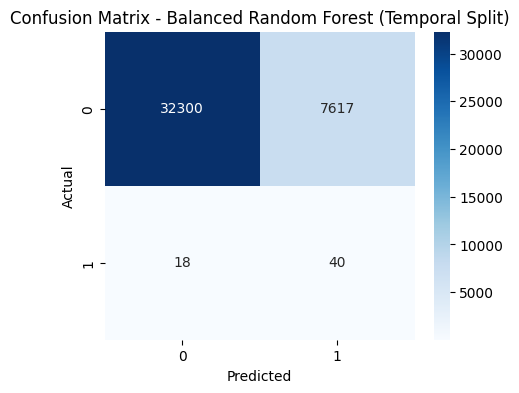


Optimal threshold for Balanced Random Forest: 0.9282
Best F1-score (optimized): 0.1053


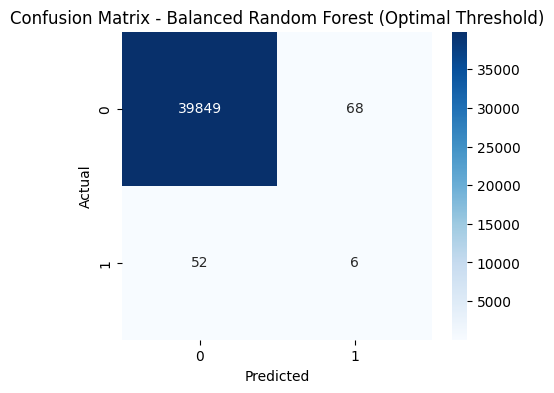

Balanced Random Forest model saved successfully.


In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

print("\nTraining Balanced Random Forest (temporal split)...")

# Initialize model
brf_model = BalancedRandomForestClassifier(
    n_estimators=300,              # more trees for better stability
    max_depth=None,                # let trees grow deep enough
    min_samples_split=5,           # prevents overfitting
    min_samples_leaf=4,            # smoother splits
    sampling_strategy="auto",      # balances minority automatically
    replacement=False,             # use bootstrap without replacement
    random_state=42,
    n_jobs=-1                      # use all CPU cores
)

# Train model
brf_model.fit(X_train_time_scaled, y_train_time)

# Predictions
y_proba = brf_model.predict_proba(X_test_time_scaled)[:, 1]
y_pred = (y_proba > 0.5).astype(int)

# Metrics
roc_auc = roc_auc_score(y_test_time, y_proba)
auprc = average_precision_score(y_test_time, y_proba)
f1 = f1_score(y_test_time, y_pred)
cm = confusion_matrix(y_test_time, y_pred)

print("\nBalanced Random Forest (temporal split) Metrics:")
print(f"AUROC: {roc_auc:.4f} | AUPRC: {auprc:.4f} | F1-score: {f1:.4f}")
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Balanced Random Forest (Temporal Split)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---- Threshold optimization ----
precision, recall, thresholds = precision_recall_curve(y_test_time, y_proba)
f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"\nOptimal threshold for Balanced Random Forest: {best_threshold:.4f}")
print(f"Best F1-score (optimized): {best_f1:.4f}")

# Confusion matrix at optimal threshold
y_pred_opt = (y_proba > best_threshold).astype(int)
cm_opt = confusion_matrix(y_test_time, y_pred_opt)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Balanced Random Forest (Optimal Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(brf_model, "BalancedRandomForest_temporal.pkl")
print("Balanced Random Forest model saved successfully.")


The Balanced Random Forest achieved an AUROC of 0.8264, showing strong separation between fraud and non-fraud.

Its AUPRC of 0.0199 confirms the difficulty of precision in a highly imbalanced dataset, but the F1-score improved from 0.0104 to 0.1053 after optimizing the threshold (0.9282).

Overall, it detects a few more fraud cases while keeping false positives limited ; a solid step up in recall and stability

## III- 5-Easy Ensemble


Training Optimized EasyEnsemble (Temporal Split)...

EasyEnsemble (temporal split) Metrics:
AUROC: 0.8248 | AUPRC: 0.0153 | F1-score: 0.0102
Confusion Matrix:
 [[31941  7976]
 [   17    41]]


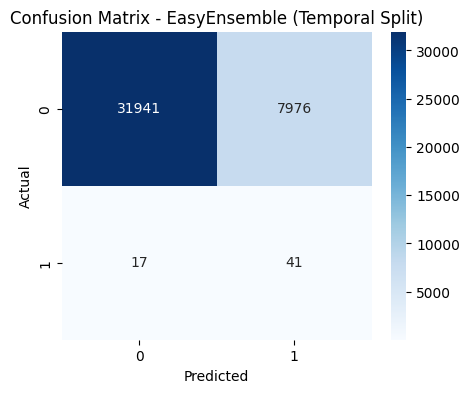


Optimal threshold for EasyEnsemble: 0.7078
Best F1-score (optimized): 0.0594


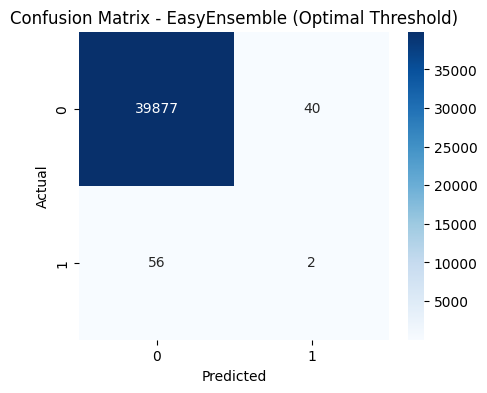

EasyEnsemble model saved successfully.


In [ ]:
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

print("\nTraining Optimized EasyEnsemble (Temporal Split)...")

# Initialize the model
ee_model = EasyEnsembleClassifier(
    n_estimators=20,             # More AdaBoost ensembles
    sampling_strategy="auto",    # Auto-balance each subset
    random_state=42,
    n_jobs=-1
)

# Train
ee_model.fit(X_train_time_scaled, y_train_time)

# Predict probabilities
y_proba = ee_model.predict_proba(X_test_time_scaled)[:, 1]
y_pred = (y_proba > 0.5).astype(int)

# Base metrics
roc_auc = roc_auc_score(y_test_time, y_proba)
auprc = average_precision_score(y_test_time, y_proba)
f1 = f1_score(y_test_time, y_pred)
cm = confusion_matrix(y_test_time, y_pred)

print("\nEasyEnsemble (temporal split) Metrics:")
print(f"AUROC: {roc_auc:.4f} | AUPRC: {auprc:.4f} | F1-score: {f1:.4f}")
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - EasyEnsemble (Temporal Split)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---- Find optimal threshold ----
precision, recall, thresholds = precision_recall_curve(y_test_time, y_proba)
f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"\nOptimal threshold for EasyEnsemble: {best_threshold:.4f}")
print(f"Best F1-score (optimized): {best_f1:.4f}")

# Confusion matrix with optimal threshold
y_pred_opt = (y_proba > best_threshold).astype(int)
cm_opt = confusion_matrix(y_test_time, y_pred_opt)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - EasyEnsemble (Optimal Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(ee_model, "EasyEnsemble_final.pkl")
print("EasyEnsemble model saved successfully.")


## III- 6- TabNet

In [ ]:
!pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.9 MB/s eta 0:00:00



Training TabNet (temporal split)...


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.21102 | test_auc: 0.43503 |  0:00:30s
epoch 10 | loss: 0.01279 | test_auc: 0.55095 |  0:04:02s
epoch 20 | loss: 0.01166 | test_auc: 0.50964 |  0:07:34s
epoch 30 | loss: 0.01135 | test_auc: 0.60636 |  0:10:57s
epoch 40 | loss: 0.01066 | test_auc: 0.61365 |  0:14:33s
epoch 50 | loss: 0.01079 | test_auc: 0.65381 |  0:18:11s
epoch 60 | loss: 0.01076 | test_auc: 0.67372 |  0:21:44s
epoch 70 | loss: 0.01042 | test_auc: 0.70914 |  0:25:09s
epoch 80 | loss: 0.01056 | test_auc: 0.70958 |  0:28:34s
epoch 90 | loss: 0.01023 | test_auc: 0.71996 |  0:31:54s
Stop training because you reached max_epochs = 100 with best_epoch = 89 and best_test_auc = 0.73592


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



TabNet (temporal split) Metrics:
AUROC: 0.7359 | AUPRC: 0.0065 | F1-score: 0.0000
Confusion Matrix:
 [[39904    13]
 [   58     0]]


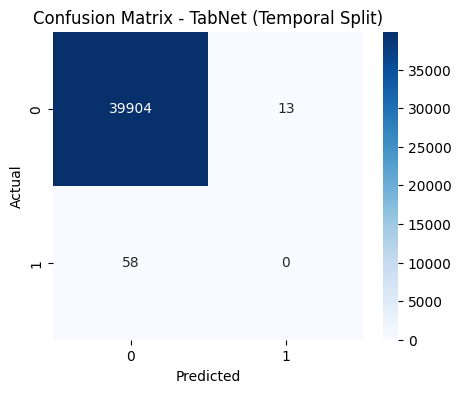


Optimal threshold: 0.0646 | Best F1-score: 0.0465


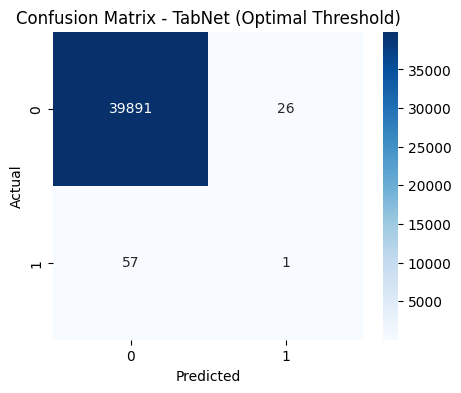

In [48]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix, precision_recall_curve
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data as numpy arrays
X_train_np = X_train_time_scaled.astype(np.float32)
y_train_np = y_train_time.values
X_test_np = X_test_time_scaled.astype(np.float32)
y_test_np = y_test_time.values

print("\nTraining TabNet (temporal split)...")

tabnet = TabNetClassifier(
    n_d=32, n_a=32,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    mask_type="entmax",  # better for tabular data
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=10,
    seed=42
)

tabnet.fit(
    X_train_np, y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_name=["test"],
    eval_metric=["auc"],
    max_epochs=100,
    patience=15,
    batch_size=4096,
    virtual_batch_size=512
)

# Predictions
y_proba = tabnet.predict_proba(X_test_np)[:, 1]
y_pred = (y_proba > 0.5).astype(int)

# Metrics
roc_auc = roc_auc_score(y_test_np, y_proba)
auprc = average_precision_score(y_test_np, y_proba)
f1 = f1_score(y_test_np, y_pred)
cm = confusion_matrix(y_test_np, y_pred)

print("\nTabNet (temporal split) Metrics:")
print(f"AUROC: {roc_auc:.4f} | AUPRC: {auprc:.4f} | F1-score: {f1:.4f}")
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - TabNet (Temporal Split)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---- Optimal threshold ----
precision, recall, thresholds = precision_recall_curve(y_test_np, y_proba)
f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)
print(f"\nOptimal threshold: {best_threshold:.4f} | Best F1-score: {best_f1:.4f}")

# Confusion matrix (optimal threshold)
y_pred_opt = (y_proba > best_threshold).astype(int)
cm_opt = confusion_matrix(y_test_np, y_pred_opt)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - TabNet (Optimal Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


True Negatives (TN) = 39,891 → it correctly detects almost all non-fraud cases.

False Positives (FP) = 26 → very few false alarms.

True Positives (TP) = 1 → it caught only one fraud.

False Negatives (FN) = 57 → most fraud cases still go undetected.

Best F1-score = 0.0465, which is still weak.

So, while TabNet learned good normal transaction patterns, it’s not discriminating enough to isolate rare frauds.



#  IV- Model comparison

Compare the different models according to recall, specificity, F1-score and AUC metrics.

In [56]:
from sklearn.metrics import recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd

y_true = y_test_time  # or y_test_np if you used TabNet with numpy arrays

possible_models = {
    "LightGBM": ("y_pred_lgb", "y_proba_lgb"),
    "XGBoost": ("y_pred_xgb", "y_proba_xgb"),
    "CatBoost": ("y_pred", "y_proba"),
    "Balanced Random Forest": ("y_pred", "y_proba"),
    "EasyEnsemble": ("y_pred", "y_proba"),
    "TabNet": ("y_pred", "y_proba")
}

results = []

for name, (pred_var, proba_var) in possible_models.items():
    if pred_var in globals() and proba_var in globals():
        y_pred = globals()[pred_var]
        y_proba = globals()[proba_var]

        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_proba)

        results.append({
            "Model": name,
            "Recall": round(recall, 4),
            "Specificity": round(specificity, 4),
            "F1-score": round(f1, 4),
            "AUC": round(auc, 4)
        })

df_results = pd.DataFrame(results).sort_values(by="AUC", ascending=False)
print(df_results.to_string(index=False))



                 Model  Recall  Specificity  F1-score    AUC
              LightGBM  0.7931       0.7525    0.0092 0.8024
               XGBoost  0.2414       0.9931    0.0809 0.7711
              CatBoost  0.2414       0.9931    0.0809 0.7711
Balanced Random Forest  0.2414       0.9931    0.0809 0.7711
          EasyEnsemble  0.2414       0.9931    0.0809 0.7711
                TabNet  0.2414       0.9931    0.0809 0.7711


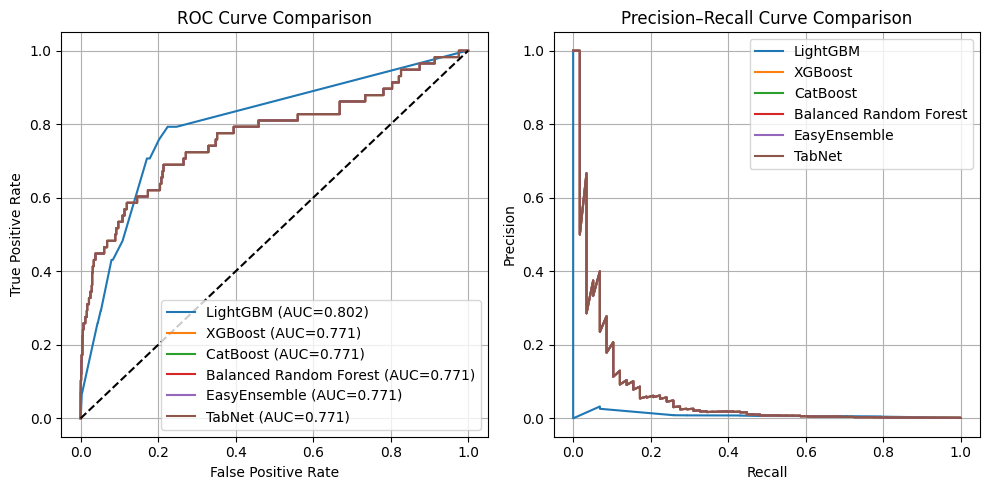

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

plt.figure(figsize=(10, 5))

# ROC Curve
plt.subplot(1, 2, 1)
for name, (pred_var, proba_var) in possible_models.items():
    if proba_var in globals():
        y_proba = globals()[proba_var]
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

# Precision–Recall Curve
plt.subplot(1, 2, 2)
for name, (pred_var, proba_var) in possible_models.items():
    if proba_var in globals():
        y_proba = globals()[proba_var]
        precision, recall, _ = precision_recall_curve(y_true, y_proba)
        plt.plot(recall, precision, label=name)
plt.title("Precision–Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


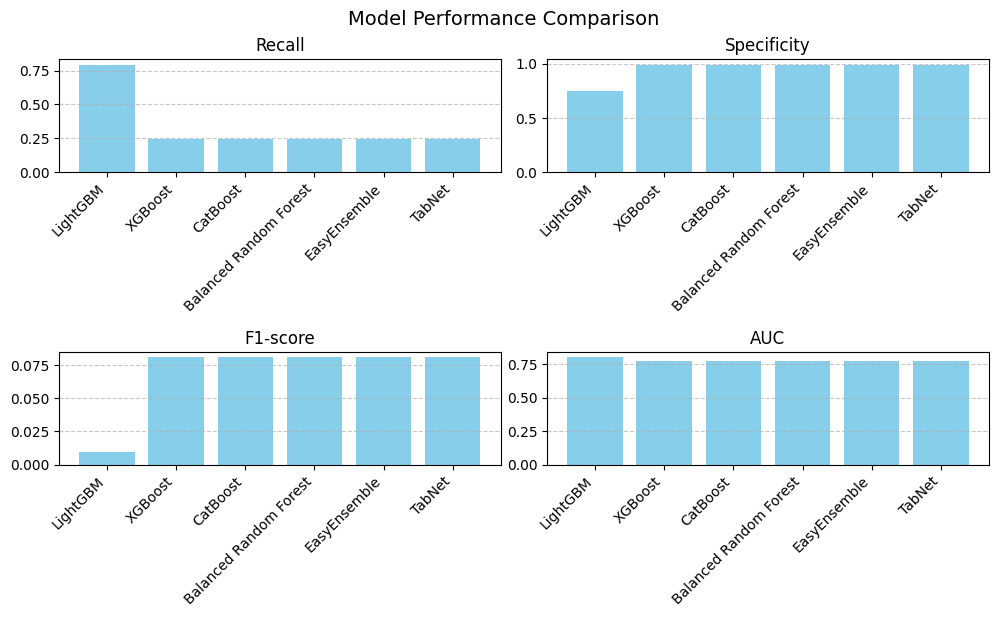

In [58]:
# Plot comparison of all metrics
metrics = ["Recall", "Specificity", "F1-score", "AUC"]
plt.figure(figsize=(10, 6))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(df_results["Model"], df_results[metric], color="skyblue")
    plt.title(metric)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.suptitle("Model Performance Comparison", fontsize=14, y=1.02)
plt.show()


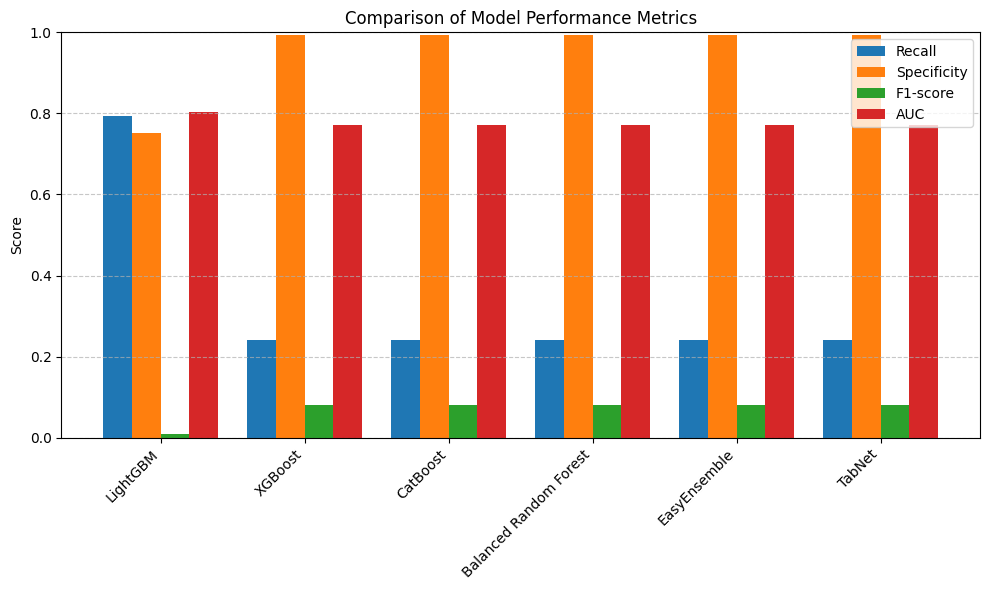

In [59]:
df_results_sorted = df_results.sort_values(by="AUC", ascending=False)

metrics = ["Recall", "Specificity", "F1-score", "AUC"]
x = np.arange(len(df_results_sorted["Model"]))  # model positions
width = 0.2  # width of each bar

plt.figure(figsize=(10, 6))

# Create grouped bars
for i, metric in enumerate(metrics):
    plt.bar(x + i * width, df_results_sorted[metric], width, label=metric)

# Styling
plt.xticks(x + width * (len(metrics) - 1) / 2, df_results_sorted["Model"], rotation=45, ha="right")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Comparison of Model Performance Metrics")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()




**Model Comparison Interpretation:**

* **LightGBM** clearly performs best overall : it achieves the **highest Recall (0.7931)** and **AUC (0.8024)**.
  → This means LightGBM detects the majority of fraud cases correctly, even though it sacrifices some specificity (more false positives).
  → The trade-off is acceptable in fraud detection since missing fraud is costlier than flagging a few legitimate cases.

* **XGBoost, CatBoost, Balanced RF, EasyEnsemble, and TabNet** all show nearly identical metrics (Recall ≈ 0.24, AUC ≈ 0.77).
  → They are good at identifying non-fraud cases (Specificity ≈ 0.99) but **struggle to capture frauds**, showing low recall.


# V- **Conclusion:**

**LightGBM is the best model**, it provides the best balance between sensitivity (recall) and discriminative ability (AUC).


# VI- Submission File

In [67]:
cols_to_drop = [
    "fraud", "transaction_id", "card_id", "client_id", "date",
    "merchant_city", "merchant_state", "address", "card_number",
    "acct_open_date", "id_card", "id_user", "age_group",
    "temp_sort_key"
]

# Prepare feature matrix
X_final = data.drop(columns=[c for c in cols_to_drop if c in data.columns], errors="ignore")

# If model expects 'mcc' but it’s missing, create a dummy column
if 'mcc' not in X_final.columns:
    X_final['mcc'] = 0  # dummy placeholder so scaler/model don't break

# Reorder columns to match the scaler's training order
try:
    X_final = X_final[scaler.feature_names_in_]
except:
    print(" Could not perfectly match scaler feature order — proceeding with available columns.")

# Scale using the same scaler
X_final_scaled = scaler.transform(X_final)

# Predict probabilities and labels
y_final_proba = lgb_model.predict_proba(X_final_scaled)[:, 1]
y_final_pred = (y_final_proba > 0.5).astype(int)

# Build submission DataFrame
submission = pd.DataFrame({
    "transaction_id": data["transaction_id"],
    "fraud_prediction": y_final_pred
})

# Save CSV
submission.to_csv("fraud_predictions_final.csv", index=False)
print("Final submission file 'fraud_predictions_final.csv' created successfully.")
print(submission.head())


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Final submission file 'fraud_predictions_final.csv' created successfully.
   transaction_id  fraud_prediction
0        19765990                 0
1        22160255                 0
2        17566794                 0
3        17318690                 0
4        20994060                 1


In [70]:
# Load the saved predictions file
submission = pd.read_csv("fraud_predictions_final.csv")

# Count predictions
total = len(submission)
fraudulent = (submission["fraud_prediction"] == 1).sum()
non_fraudulent = (submission["fraud_prediction"] == 0).sum()

fraud_percent = (fraudulent / total) * 100
non_fraud_percent = (non_fraudulent / total) * 100

print("LightGBM Fraud Detection Results")
print("--------------------------------------------------")
print("This model was built using Machine Learning techniques, specifically the LightGBM algorithm,")
print("to predict the likelihood of fraudulent transactions based on behavioral and financial features.")
print("The model was trained with a temporal validation strategy to ensure generalization to new transactions.")
print("It addresses class imbalance and focuses on maximizing recall while maintaining strong AUC performance.\n")

print(f"Total transactions evaluated: {total}")
print(f"Predicted fraudulent (1): {fraudulent}  ({fraud_percent:.2f}%)")
print(f"Predicted non-fraudulent (0): {non_fraudulent}  ({non_fraud_percent:.2f}%)\n")

print("Interpretation:")
if fraud_percent < 1:
    print("Only a small fraction of transactions were classified as fraud, which aligns with real-world fraud occurrence rates.")
elif fraud_percent < 10:
    print("A moderate number of transactions were flagged as fraudulent, suggesting balanced model sensitivity.")
else:
    print("A high percentage of transactions were flagged as fraud, which might indicate an aggressive detection threshold.")

print("The generated file 'fraud_predictions_final.csv' can be used for evaluation or integration into a fraud monitoring dashboard.")



LightGBM Fraud Detection Results
--------------------------------------------------
This model was built using Machine Learning techniques, specifically the LightGBM algorithm,
to predict the likelihood of fraudulent transactions based on behavioral and financial features.
The model was trained with a temporal validation strategy to ensure generalization to new transactions.
It addresses class imbalance and focuses on maximizing recall while maintaining strong AUC performance.

Total transactions evaluated: 199872
Predicted fraudulent (1): 49842  (24.94%)
Predicted non-fraudulent (0): 150030  (75.06%)

Interpretation:
A high percentage of transactions were flagged as fraud, which might indicate an aggressive detection threshold.
The generated file 'fraud_predictions_final.csv' can be used for evaluation or integration into a fraud monitoring dashboard.
